## Detecting COVID-19 in X-Ray Lung Scans

**Notes**
20.03.2020
reading Chest x-rays with pneumonia
https://www.youtube.com/watch?v=HBS-DJ9ez-c

**Learning / Goals:**
- using multiple Datasources in Kaggle
- using tensorboard and callbacks in Kaggle
- Pretrained CNN and Data Preprocessing 



## Table of Content


1. Setup
2. Data Loading and Preprocessing
    1. Covid X-Ray dataset
    2. 'Normal' Pneumonia dataset
    3. Plot X-Rays
    4. Data Preprocessing
    5. get labels, resize, normalize etc
    6. One-Hot-encoder and ImageDataGenerator
3. Build model 
    1. Functional 5x Conv2D BN Dropout / fc
    2. callbacks 3x ModelCh., LR, tensorboard
    3. Resnet34 import as base
    4. Train model
4. Prediction
5. Evaluation
    1. Visualization w. Grad-CAM
    2. ROC-AUC w. Plot
    3. Confusion-Matrix
    4. Confusion Matrix 

## 1. Setup


In [1]:
!pip install imutils
!pip install image-classifiers==1.0.0b1

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=5c75c0cf9a067ed46b766dc155577af8975a20d0116a9ee2361cb2fbdb4455a1
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0b1-py3-none-any.whl size=19954 sha256=82e68c1ec5c7a587b717d69fbef1b5fe65da32f59e9e607253d5824966461425
  Stored in directory: /root/.cache/pip/wheels/62/1d/1d/d551ddb7ef02acac3373cb39ccd101661f28635a0d91febb69
Successfully built image-classifiers
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [11]:
# make clear for what it is used !!!

# general purpose
import tensorflow as tf

from imutils import paths # libary with helpful .list_images() 
import matplotlib as plt

import random
import shutil #copy file from/to directory
import cv2 # basic data processing
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Loading & Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import (train_test_split, StratifiedKFold, 
RepeatedStratifiedKFold)

#Model
from tensorflow.keras.applications import VGG16, DenseNet169

from tensorflow.keras.layers import (AveragePooling2D, GlobalAveragePooling2D, BatchNormalization, Activation,
Dropout, Flatten, Dense, Input, Lambda, Reshape, DepthwiseConv2D, ZeroPadding2D, Add, MaxPooling2D,
Conv2D, Concatenate)

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint,
ReduceLROnPlateau, TensorBoard, TerminateOnNaN, LearningRateScheduler)

from tensorflow.keras.losses import binary_crossentropy
from classification_models.tfkeras import Classifiers # not found

# Evaluation 
from sklearn.metrics import (classification_report, confusion_matrix,
roc_auc_score, roc_curve, auc)

# Misc
from datetime import datetime # to create log files for tensorboard with datetime.now()

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### 2. Data Loading and Preprocessing

    2.1 Basic Setup
    2.2 Covid Images (Datasource 1)
    2.3 Pneumonia & Normal Images (Datasource 2)
    2.4 Data Preprocessing

### 2.1. Basic Setup

In [3]:
dataset_path = './dataset'
log_path = './logs'

create output structure

In [12]:
%%bash
rm -rf dataset
mkdir -p dataset/covid
mkdir -p dataset/normal
mkdir -p dataset/pneumonia
mkdir -p logs

## 2.2 Covid X-Ray Images

In [14]:
# Number of covid images
len(os.listdir("../input/covid-chest-xray/images/"))

357

### Side Info
Difference in X-Rays

AP, X-ray: An X-ray picture in which the beams pass from front-to-back (anteroposterior). As opposed to a PA (posteroanterior) film in which the rays pass through the body from back-to-front.
The heart shadow is magnified because it is an anterior structure. ... The AP shows magnification of the heart and widening of the mediastinum. Whenever possible the patient should be imaged in an upright PA position. AP views are less useful and should be reserved for very ill patients who cannot stand erect.
L = Lateral Position

In [15]:
# limit images to 141 so all classes (normal, covid, and pneumonia xrays) are equal numbers)
samples = 141

In [16]:
covid_dataset_path = '../input/covid-chest-xray'

# get list of all cases from metadata.csv
csvPath = os.path.sep.join([covid_dataset_path, "metadata.csv"])
df = pd.read_csv(csvPath)
# print(df.head()) quick look

# find rows with Covid-19 in "finding row" and extract those images
for (i, row) in df.iterrows():
    
    # ignore all rows not Covid or PA
    if row['finding'] != "COVID-19" or row["view"] != "PA":
        continue
    
    # create filepaths for all Covid XRays in PA
    imagePath = os.path.sep.join([covid_dataset_path, "images", row['filename']])
    
    # if file not existing, skip 
    if not os.path.exists(imagePath):
        continue
    
    # get filename and create path for new folder of this xray image
    filename = row['filename'].split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/covid", filename])
    
    shutil.copy2(imagePath, outputPath)

In [17]:
# Number of Covid X-Rays
len(os.listdir("./dataset/covid/"))

141

### 2.3 Build Normal/Pneumonia Dataset
    1. Trainig-Normal (No pneumonia) Images
    2. Training-Pneumonia Images


In [18]:
basePath = '../input/chest-xray-pneumonia/chest_xray'

In [23]:
basePath_pneumonia = os.path.sep.join([basePath, "train", "NORMAL"])
imagePaths = list(paths.list_images(basePath_pneumonia))

len(imagePaths)

# randomly sample the image paths
random.seed(42)
random.shuffle(imagePaths)
imagePaths = imagePaths[:samples]

print(np.array(imagePaths).shape) # Number of Images we use from input path

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/normal", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

 #Number of Normal Chest Xrays images new in output directory 
print(len(os.listdir("./dataset/normal")))

(141,)
141


In [25]:
train_pneumonia_path = os.path.sep.join([basePath, "train", "PNEUMONIA"])

imagePaths = list(paths.list_images(train_pneumonia_path))

random.seed(42)
random.shuffle(imagePaths)
imagePaths = imagePaths[:samples]

for (i, imagePath) in enumerate(imagePaths):
    
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/pneumonia", filename])
    
    shutil.copy2(imagePath, outputPath)
len(os.listdir('./dataset/pneumonia'))

141

### 2.4 Data Preprocessing

- convert labels to 2,1 or 0
- read in img, resize, color conversion
- np.array and Normalization of byte values

In [34]:
# create array of all images

label_dict = {"pneumonia": 2, "covid": 1, "normal": 0}

imagePaths = list(paths.list_images(dataset_path))

images = []
labels = []

for imagePath in imagePaths:
    # get the name of last dir for label
    label = imagePath.split(os.path.sep)[-2]
    
    # images
    img = cv2.imread(imagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)
    
    images.append(img)
    labels.append(label_dict[label])
    
images = np.array(images) / 255. # transform to np.array, normalization and int to float
labels = np.array(labels)
len(images)

423

### Splitting / Encoding categories / Data Augmentation



In [36]:
# splitting data
(X_train, X_test, y_train, y_test) = train_test_split(images, labels, test_size=0.15, 
                                                        stratify = labels, random_state=42)

# Data Augmention setup
train_datagen = ImageDataGenerator(rotation_range = 60,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = "nearest")

valid_datagen = ImageDataGenerator()

# encoding One-Hot-Encoder (trainYSparse as backup)
trainYSparse = y_train
y_train = to_categorical(y_train)

print(len(X_train), len(X_test))

359 64


## 3. Model

    3.1 create model
    3.2 callbacks and SKF
    3.4 Model with for_loop SKF
    

### 3.1 Model from scratch

In [37]:
def create_base_model(img_size):
    
    weight_decay = 1e-4
    
    # input layer
    input = Input(shape=(img_size, img_size, 3), dtype=tf.float32)
    
    # stack of Conv. Layers w. relu, BN, MaxPooling and dropout
    
    #no. 1
    conv = Conv2D(32, (5, 5))(input)
    conv_acti = Activation("relu")(conv)
    conv_bn = BatchNormalization()(conv_acti)
    conv_pool = MaxPooling2D()(conv_bn)
    conv_dropout = Dropout(0.1)(conv_pool)
    
    #no. 2 (64 feature maps, kernel size 3x3, dropout 0.2)
    conv = Conv2D(64, (3, 3))(conv_dropout)
    conv_acti = Activation("relu")(conv)
    conv_bn = BatchNormalization()(conv_acti)
    conv_pool = MaxPooling2D()(conv_bn)
    conv_dropout = Dropout(0.2)(conv_pool)
    
    #no. 3 (128 feature maps, kernel size 3x3, dropout 0.3)
    conv = Conv2D(128, (3, 3))(conv_dropout)
    conv_acti = Activation("relu")(conv)
    conv_bn = BatchNormalization()(conv_acti)
    conv_pool = MaxPooling2D()(conv_bn)
    conv_dropout = Dropout(0.3)(conv_pool)
    
    #no. 4(256 feature maps, kernel size 3x3, dropout 0.3)
    conv = Conv2D(256, (3, 3))(conv_dropout)
    conv_acti = Activation("relu")(conv)
    conv_bn = BatchNormalization()(conv_acti)
    conv_pool = MaxPooling2D()(conv_bn)
    conv_dropout = Dropout(0.4)(conv_pool)
    
    #no. 5
    conv = Conv2D(512, (3, 3))(conv_dropout)
    conv_acti = Activation("relu")(conv)
    conv_bn = BatchNormalization()(conv_acti)
    conv_pool = MaxPooling2D()(conv_bn)
    conv_dropout = Dropout(0.5)(conv_pool)
    
    # Pooling layer
    gap2d = GlobalAveragePooling2D()(conv_dropout)
    act = Activation("relu")(gap2d)
    bn = BatchNormalization()(act)
    dropout = Dropout(0.3)(bn)
    
    # Fully Connected Layer
    fc = Dense(256)(dropout)
    act= Activation("relu")(fc)
    bn = BatchNormalization()(act)
    dropout = Dropout(0.4)(bn)
    
    # Output Layer (3 units for each class, softmax)
    output = Dense(3, activation='softmax')(dropout)
    
    # create Model
    model = tf.keras.Model(input, output, name="baseline")
    
    return model

# create Model with 224 x 224 img size as input
model_basic = create_base_model(224)

## 3.2 Densenet121 Architecture Model (pretrained) with Callbacks, SKF



In [41]:
from math import floor

# Define Parameters
# sfk
N_FOLDS = 8

# for LearningRateScheduler
INIT_LR = 3e-4
decay_rate = 0.95
decay_step = 1

# StratifiedKFold
skf = StratifiedKFold(n_splits = N_FOLDS, random_state = 1234)

# Callbacks
# TensorBoard
log_dir = "./logs" + datetime.now().strftime("%Y%m%d - %H%M%S")
tensorboard_cb = TensorBoard(log_dir = log_dir, histogram_freq = 1)
#ModelCheckpoint
modelcheckpoint_cb = ModelCheckpoint(filepath = 'best_model.h5', monitor="val_loss",
                                    mode = 'min', verbose = 1, save_best_only = True,
                                    save_weights_only = True)
#EarlyStopping
earlystopping_cb = EarlyStopping(mode= "auto", patience = 5, monitor= "val_loss", restore_best_weights = True)

#LearningRate
lr_cb = LearningRateScheduler( lambda epoch: INIT_LR * pow(decay_rate, floor(epoch / decay_step)))

# combining all callbacks
callbacks = [tensorboard_cb, modelcheckpoint_cb, earlystopping_cb, lr_cb]

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [39]:
# create Model with pretrained densenet121

# pretrained base
dense121, _ = Classifiers.get('densenet121')
conv_base = dense121(weights= "imagenet",
                     include_top = False,
                     input_shape = (224, 224, 3))

conv_base.trainable = False # option 2: for layers in conv_base.layers: trainable = False

# add top layers
gap2d = GlobalAveragePooling2D()(conv_base.output)
act = Activation("relu")(gap2d)
bn = BatchNormalization()(act)
dropout = Dropout(0.3)(bn)

fc1 = Dense(256)(dropout)
act = Activation("relu")(fc1)
bn = BatchNormalization()(act)
dropout = Dropout(0.4)(bn)
output = Dense(3, activation="softmax")(dropout)

model_densenet = Model(conv_base.input, output)

model_densenet.compile(loss="categorical_crossentropy",
             optimizer= Adam(lr= INIT_LR),
             metrics = ["acc", tf.keras.metrics.AUC()])

### 3.3 Train model with additional visualization while training

1. for loop with epoch, skf_splits
2. create and train Model
4. Visualize Train and Valid Loss with .plot()

Train for 19 steps, validate for 2 steps
Epoch 1/8
18/19 [===========================>..] - ETA: 0s - loss: 0.7563 - acc: 0.7092 - auc_11: 0.8736
Epoch 00001: val_loss did not improve from 1.07705
19/19 [==============================] - 21s 1s/step - loss: 0.7424 - acc: 0.7148 - auc_11: 0.8788 - val_loss: 1.1811 - val_acc: 0.3750 - val_auc_11: 0.7107
Epoch 2/8
18/19 [===========================>..] - ETA: 0s - loss: 0.3319 - acc: 0.8958 - auc_11: 0.9711 ETA: 1s - loss: 0.3431 - acc: 0.8795 - auc_11
Epoch 00002: val_loss improved from 1.07705 to 1.01106, saving model to best_model.h5
19/19 [==============================] - 7s 356ms/step - loss: 0.3493 - acc: 0.8914 - auc_11: 0.9691 - val_loss: 1.0111 - val_acc: 0.4688 - val_auc_11: 0.7346
Epoch 3/8
18/19 [===========================>..] - ETA: 0s - loss: 0.3480 - acc: 0.8794 - auc_11: 0.9683
Epoch 00003: val_loss improved from 1.01106 to 1.00471, saving model to best_model.h5
19/19 [==============================] - 6s 320ms/step - lo

18/19 [===========================>..] - ETA: 0s - loss: 0.1851 - acc: 0.9255 - auc_14: 0.9891
Epoch 00003: val_loss did not improve from 0.04631
19/19 [==============================] - 5s 279ms/step - loss: 0.1841 - acc: 0.9262 - auc_14: 0.9892 - val_loss: 0.0624 - val_acc: 0.9375 - val_auc_14: 0.9980
Epoch 4/8
18/19 [===========================>..] - ETA: 0s - loss: 0.2310 - acc: 0.9220 - auc_14: 0.9858
Epoch 00004: val_loss did not improve from 0.04631
19/19 [==============================] - 5s 251ms/step - loss: 0.2200 - acc: 0.9262 - auc_14: 0.9868 - val_loss: 0.1966 - val_acc: 0.9688 - val_auc_14: 0.9895
Epoch 5/8
18/19 [===========================>..] - ETA: 0s - loss: 0.2095 - acc: 0.9236 - auc_14: 0.9867
Epoch 00005: val_loss did not improve from 0.04631
19/19 [==============================] - 5s 270ms/step - loss: 0.2037 - acc: 0.9243 - auc_14: 0.9872 - val_loss: 1.2004 - val_acc: 0.7188 - val_auc_14: 0.8940
Epoch 6/8
18/19 [===========================>..] - ETA: 0s - loss

Epoch 5/8
18/19 [===========================>..] - ETA: 0s - loss: 0.2007 - acc: 0.9362 - auc_17: 0.9869
Epoch 00005: val_loss did not improve from 0.04631
19/19 [==============================] - 5s 252ms/step - loss: 0.1942 - acc: 0.9396 - auc_17: 0.9874 - val_loss: 2.7713 - val_acc: 0.5312 - val_auc_17: 0.6985
Epoch 6/8
18/19 [===========================>..] - ETA: 0s - loss: 0.0734 - acc: 0.9645 - auc_17: 0.9985
Epoch 00006: val_loss did not improve from 0.04631
19/19 [==============================] - 5s 272ms/step - loss: 0.0779 - acc: 0.9631 - auc_17: 0.9983 - val_loss: 1.2600 - val_acc: 0.5938 - val_auc_17: 0.8425
Epoch 7/8
18/19 [===========================>..] - ETA: 0s - loss: 0.1066 - acc: 0.9681 - auc_17: 0.9965
Epoch 00007: val_loss did not improve from 0.04631
19/19 [==============================] - 5s 277ms/step - loss: 0.1031 - acc: 0.9698 - auc_17: 0.9967 - val_loss: 1.1119 - val_acc: 0.8125 - val_auc_17: 0.8940
Epoch 8/8
18/19 [===========================>..] - ETA:

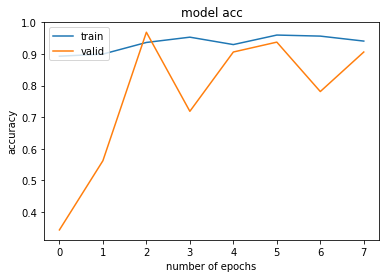

In [45]:
submission_predictions = []

# Parameters
T_BatchSize = 16
V_BatchSize = 16
N_FOLDS = 8
EPOCHS = 8


for epoch, skf_split in zip(range(0, N_FOLDS), skf.split(X_train, trainYSparse)):
    
    train_skf_idx = skf_split[0] # original train_idx nameing
    val_skf_idx = skf_split[1]
    
    # create Model
    ## base layers pretrained resnet34
    densenet121, _ = Classifiers.get("densenet121")
    conv_base = densenet121(weights= 'imagenet',
                        include_top = False,
                        input_shape = (224, 224, 3))
    
    conv_base.trainabel = False
    
    ## top layers 
    gap2d = GlobalAveragePooling2D()(conv_base.output)
    act = Activation('relu')(gap2d)
    batch = BatchNormalization()(act)
    dropout = Dropout(0.3)(batch)

    fc1 = Dense(256)(dropout)
    act = Activation('relu')(fc1)
    batch = BatchNormalization()(act)
    dropout = Dropout(0.4)(batch)
    output = Dense(3, activation='softmax')(dropout)
    
    model = Model(conv_base.input, output)
    
    model.compile(loss = "categorical_crossentropy",
                 optimizer = Adam(lr = INIT_LR),
                 metrics = ["acc", tf.keras.metrics.AUC()])
    
    if epoch != 0:
        model.load_weights("best_model.h5")
        
    history = model.fit(train_datagen.flow(X_train[train_skf_idx], y_train[train_skf_idx], 
                                            batch_size = T_BatchSize),
                         steps_per_epoch = len(train_skf_idx) // T_BatchSize,
                         epochs = EPOCHS,
                         validation_data = valid_datagen.flow(X_train[val_skf_idx], y_train[val_skf_idx],
                                                           batch_size = V_BatchSize),
                         validation_steps = len(val_skf_idx) // V_BatchSize,
                         callbacks = callbacks
                        )
    if epoch >=1 :
        y_pred = model.predict(X_test, batch_size = V_BatchSize)
        submission_predictions.append(y_pred)
    
    
    ## Plot the train and valid. loss
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='valid')
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("number of epochs")
    plt.legend(["train", "valid"], loc="upper left")
    plt.savefig('loss_performance'+'_'+str(epoch)+'.png')
    plt.clf()
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='valid')
    plt.title("model acc")
    plt.ylabel("accuracy")
    plt.xlabel("number of epochs")
    plt.legend(["train", "valid"], loc="upper left")
    plt.savefig('acc_performance'+'_'+str(epoch)+'.png')
    
    
    del history
    del model

### 4. Interference

In [46]:
model_densenet.load_weights("../working/best_model.h5")

In [47]:
# get index (normal == 0)
print("Normal ", np.where(y_test == 0), np.array(np.where(y_test == 0)).shape)
print('Covid 19', np.where(y_test == 1))
print("Pneumonia ", np.where(y_test == 2))

Normal  (array([ 1,  7,  9, 10, 11, 19, 20, 21, 23, 28, 33, 35, 36, 37, 38, 42, 46,
       47, 49, 50, 63]),) (1, 21)
Covid 19 (array([ 0,  3,  4, 14, 15, 18, 22, 25, 29, 30, 31, 32, 34, 48, 52, 53, 55,
       56, 57, 60, 62]),)
Pneumonia  (array([ 2,  5,  6,  8, 12, 13, 16, 17, 24, 26, 27, 39, 40, 41, 43, 44, 45,
       51, 54, 58, 59, 61]),)


In [48]:
# test with one image with healthy lung

image = X_test[7] # index see array above
y_pred = model_densenet.predict(image[np.newaxis, ...])
y_pred


array([[9.4751048e-01, 1.2162590e-05, 5.2477345e-02]], dtype=float32)

## 5. Test and evaluation

1. Visualization with Grad-CAM



### 5.1 Visualization with Grad-CAM

In [49]:
class GradCAM:
	def __init__(self, model, classIdx, layerName=None):
		# store the model, the class index used to measure the class
		# activation map, and the layer to be used when visualizing
		# the class activation map
		self.model = model
		self.classIdx = classIdx
		self.layerName = layerName

		# if the layer name is None, attempt to automatically find
		# the target output layer
		if self.layerName is None:
			self.layerName = self.find_target_layer()

	def find_target_layer(self):
		# attempt to find the final convolutional layer in the network
		# by looping over the layers of the network in reverse order
		for layer in reversed(self.model.layers):
			# check to see if the layer has a 4D output
			if len(layer.output_shape) == 4:
				return layer.name

		# otherwise, we could not find a 4D layer so the GradCAM
		# algorithm cannot be applied
		raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

	def compute_heatmap(self, image, eps=1e-8):
		# construct our gradient model by supplying (1) the inputs
		# to our pre-trained model, (2) the output of the (presumably)
		# final 4D layer in the network, and (3) the output of the
		# softmax activations from the model
		gradModel = Model(
			inputs=[self.model.inputs],
			outputs=[self.model.get_layer(self.layerName).output, 
                     
				self.model.output])

		# record operations for automatic differentiation
		with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
			inputs = tf.cast(image, tf.float32)
			(convOutputs, predictions) = gradModel(inputs)
			loss = predictions[:, self.classIdx]

		# use automatic differentiation to compute the gradients
		grads = tape.gradient(loss, convOutputs)

		# compute the guided gradients
		castConvOutputs = tf.cast(convOutputs > 0, "float32")
		castGrads = tf.cast(grads > 0, "float32")
		guidedGrads = castConvOutputs * castGrads * grads

		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
		convOutputs = convOutputs[0]
		guidedGrads = guidedGrads[0]

		# compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
		weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
		cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

		# grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
		(w, h) = (image.shape[2], image.shape[1])
		heatmap = cv2.resize(cam.numpy(), (w, h))

		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
		numer = heatmap - np.min(heatmap)
		denom = (heatmap.max() - heatmap.min()) + eps
		heatmap = numer / denom
		heatmap = (heatmap * 255).astype("uint8")

		# return the resulting heatmap to the calling function
		return heatmap

	def overlay_heatmap(self, heatmap, image, alpha=0.5,
		colormap=cv2.COLORMAP_JET):
		# apply the supplied color map to the heatmap and then
		# overlay the heatmap on the input image
		heatmap = cv2.applyColorMap(heatmap, colormap)
		output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

		# return a 2-tuple of the color mapped heatmap and the output,
		# overlaid image
		return (heatmap, output)

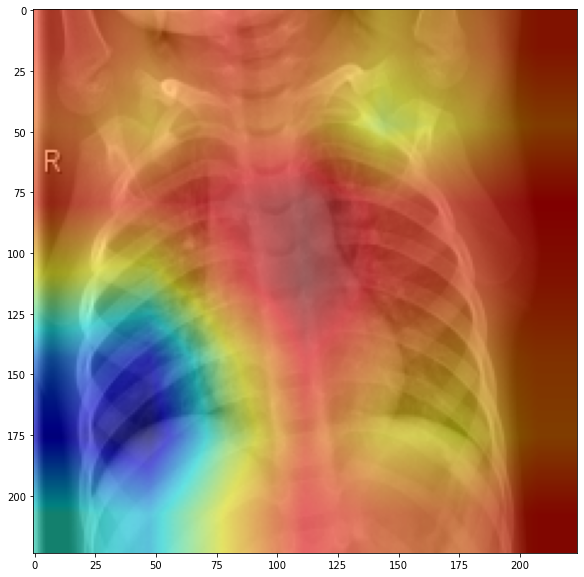

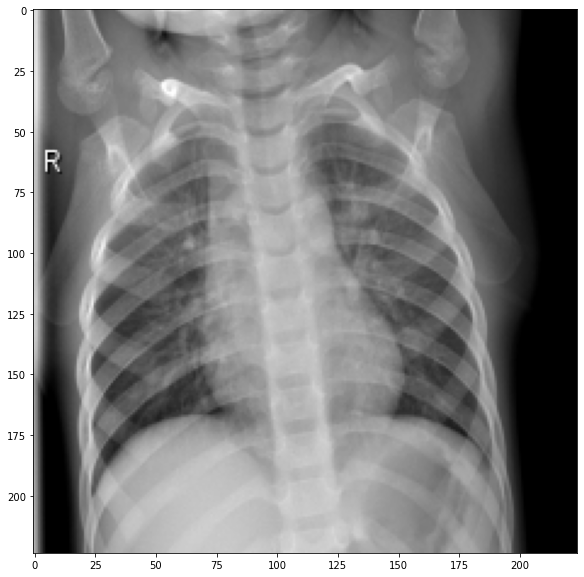

In [50]:
## GRAD-Cam for 1 healthy image

# predicted class of image at X_test[7] - result 0 == "normal" lung
i = np.argmax(y_pred[0])

# Initialize Grad-Cam object and build the heatmap for image[np.newaxis, ...] (X_test[7])
cam = GradCAM(model_densenet, i)
heatmap = cam.compute_heatmap(image[np.newaxis, ...])

# transform a copy of the image to "normal" format
img_copy = np.copy(image)
#print(img_copy)
# remodel so it's redable
img_copy -= img_copy.min((0,1))
#print(img_copy)
img_copy = (255* img_copy).astype(np.uint8)
#print(img_copy)

# resize heatmap (so it fits input image) - then overlay heatmap & image
heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
(heatmap, output_CAM) = cam.overlay_heatmap(heatmap, img_copy, alpha = 0.5)


plt.figure(figsize= (10,10))
plt.imshow(output_CAM, cmap = "gray")
plt.figure(figsize= (10,10))
plt.imshow(img_copy)

In [54]:
# plot multiple  Covid Grad-Cam

def plot_map(img_list):
    fig, axes = plt.subplots(len(img_list), 2, figsize=(10,10))
    fig.suptitle('Covid Grad-CAM\n',fontsize=20)
    
    for i, img in enumerate(img_list):
        preds = model_densenet.predict(img[np.newaxis,...])
        axes[i,0].imshow(img, cmap = 'bone')
        axes[i,0].set_xticks([])
        axes[i,0].set_yticks([])
        #axes[i,0].set_title(f'{class_label[np.argmax(preds[:, 1:]) + 1]} / {class_label[np.argmax(label[:, 1:]) + 1]} / {np.max(preds[:, 1:]):.4f}')
        heatmap = cam.compute_heatmap(img[np.newaxis,...])
        img_copy = np.copy(img)
        img_copy -= img_copy.min((0,1))
        img_copy = (255*img_copy).astype(np.uint8)
        # resize the resulting heatmap to the original input image dimensions
        # and then overlay heatmap on top of the image
        heatmap = cv2.resize(heatmap, (img_copy.shape[1], img_copy.shape[0]))
        (heatmap, output) = cam.overlay_heatmap(heatmap, img_copy, alpha=0.5)
        
        axes[i,1].imshow(output)
        axes[i,1].set_xticks([])
        axes[i,1].set_yticks([])
        axes[i,1].set_title("heatmap showing (covid) hemorrhage location")
    plt.subplots_adjust(wspace=1, hspace=0.2)
    plt.savefig('CovidGradCAM.png')

In [63]:
covid_list = np.where(y_test == 1)
pneumonia_list = np.where(y_test == 2)

print(covid_list)
covid_img_list = [X_test[3], X_test[4]]
# pneumonia_test_list = [X_test[1], X_test[13], X_test[40]]

(array([ 0,  3,  4, 14, 15, 18, 22, 25, 29, 30, 31, 32, 34, 48, 52, 53, 55,
       56, 57, 60, 62]),)


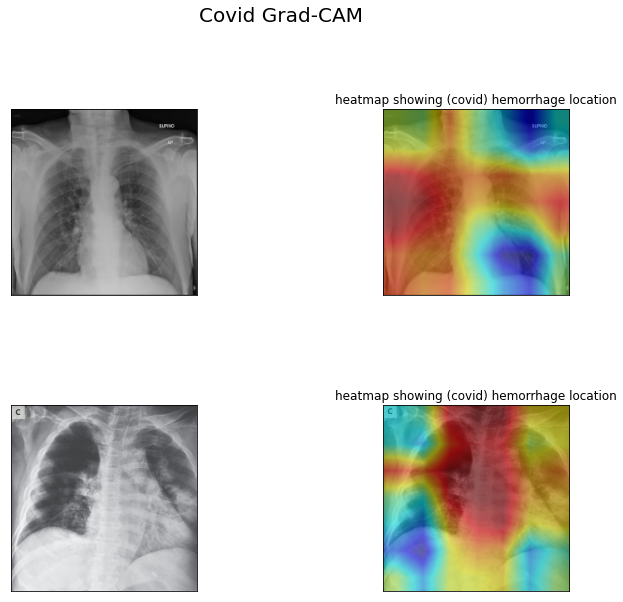

In [64]:
plot_map(covid_img_list)

### 5.2 Evaluation Metrics


In [65]:
y_pred_avg = np.average(submission_predictions, axis = 0, weights = [2**i for i in range(len(submission_predictions))])
y_pred_avg.shape

(64, 3)

#### 5.2.1 ROC 

reciever operating characteristic curve ROC Curve


In [66]:
roc_auc_score(y_test, y_pred_avg, multi_class = 'ovr')

0.9941357092519884

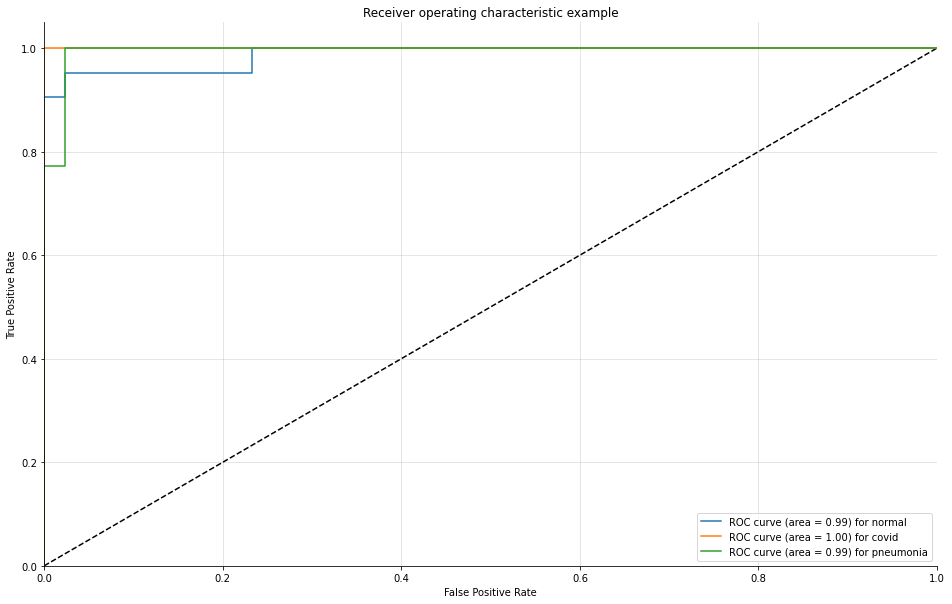

In [67]:
class_to_label_map = {2 : 'pneumonia', 1 : 'covid', 0 : 'normal'}

import seaborn as sns
def plot_multiclass_roc(y_test, y_score, n_classes, figsize=(17, 6)):

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], class_to_label_map[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(y_test, y_pred_avg, n_classes=3, figsize=(16, 10))

#### 5.2.2 confusion matrix


In [68]:
print(y_pred_avg)

[[4.45162313e-02 8.47587121e-01 1.07896624e-01]
 [8.89099009e-01 1.19646864e-03 1.09704560e-01]
 [7.81825938e-02 5.39287821e-03 9.16424503e-01]
 [9.05580901e-03 7.51764381e-01 2.39179794e-01]
 [3.93111916e-02 6.72485777e-01 2.88203056e-01]
 [3.53747677e-02 2.17302431e-02 9.42894991e-01]
 [4.26358248e-04 1.31582183e-03 9.98257813e-01]
 [9.35302084e-01 1.03266181e-04 6.45946012e-02]
 [3.00125342e-03 1.03476234e-03 9.95963993e-01]
 [9.86412282e-01 2.24338362e-03 1.13443148e-02]
 [9.94299732e-01 7.23354864e-05 5.62797190e-03]
 [9.99081084e-01 7.62268282e-05 8.42734513e-04]
 [2.52852029e-01 3.01006690e-04 7.46846951e-01]
 [1.21155487e-02 2.76391134e-02 9.60245321e-01]
 [1.10653540e-04 8.45601484e-01 1.54287837e-01]
 [9.81523315e-02 8.54450693e-01 4.73969998e-02]
 [4.82349401e-04 5.69871826e-03 9.93818957e-01]
 [2.04444835e-04 6.08949515e-06 9.99789443e-01]
 [2.90011859e-03 9.65003759e-01 3.20961642e-02]
 [9.37014975e-01 6.42175767e-05 6.29208535e-02]
 [9.91687227e-01 8.57530472e-04 7.455227

In [69]:
y_predictions = np.argmax(y_pred_avg, axis = -1)
conf_matrix = confusion_matrix(y_test, y_predictions)
conf_matrix

array([[19,  0,  2],
       [ 1, 19,  1],
       [ 0,  0, 22]])

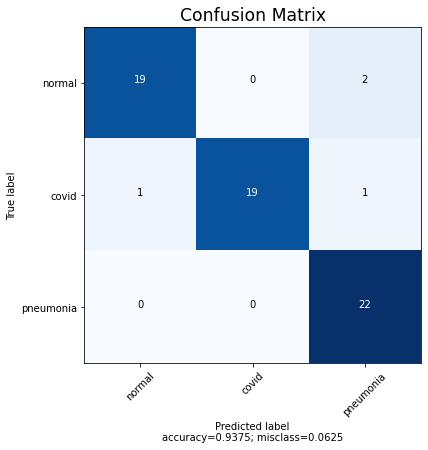

In [70]:
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix
    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']
    title:        the text to display at the top of the matrix
    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 'xx-large')

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
plot_confusion_matrix(conf_matrix, 
                      normalize = False,
                      target_names = ['normal', 'covid', 'pneumonia'],
                      title        = "Confusion Matrix")

### 6. Tensorboard

In [71]:
# tensorboard --helpful

ERROR: Failed to launch TensorBoard (exited with 0).
Contents of stderr:
2021-04-03 22:30:48.711416: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Contents of stdout:
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--purge_orphaned_data BOOL] [--db URI] [--db_import]
                   [--inspect] [--version_tb] [--tag TAG] [--event_file PATH]
                   [--path_prefix PATH] [--window_title TEXT]
                   [--max_reload_threads COUNT] [--reload_interval SECONDS]
                   [--reload_task TYPE] [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [--debugger_data_server_grpc_port PORT]
                   [--debugger_port PORT] [-

In [75]:
# %tensorboard --log_dir ./logs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2021-04-03 22:32:57.242941: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Error: A logdir or db must be specified. For example `tensorboard --logdir mylogdir` or `tensorboard --db sqlite:~/.tensorboard.db`. Run `tensorboard --helpfull` for details and examples.